### Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from tqdm import tqdm

from modules.unet import UNet
from modules.unet import dice_loss, dice_coeff, multiclass_dice_coeff
from torch.optim.lr_scheduler import _LRScheduler
from IPython.display import clear_output
from torchmetrics import StructuralSimilarityIndexMeasure, PeakSignalNoiseRatio
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore 
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity

print('imported')

imported


### Constants

In [2]:
# working device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Selected device: {}'.format(device))
print('Device name: {}'.format(torch.cuda.get_device_name(device)))

# other cosntants
# you can modify from here: and only modify whats possible to modify (for backbones and optimizers)
BATCH_SIZE = 32
EPOCHS = 40
IMG_SIZE = (128, 128)
LEARNING_RATE = 0.0001
IN_CHANNELS = 1

class IdentityDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.x.shape[0]

Selected device: cuda
Device name: NVIDIA RTX A6000


### Loading data

In [39]:
import torchvision.transforms as transforms
import numpy as np

# real_data = np.load(os.path.join(DATA_DIR, 'seg_train_data.npy'))
# real_data = np.load('./data/brats_preprocessed.npy') # 3D data
real_data = np.load('data/brats_preprocessed.npy')
train_data, test_data = real_data[60:90], real_data[100:130]  # 30 samples for training, 30 for testing

def process_data(real_data):
    real_data = real_data.transpose(0, 4, 1, 2, 3)
    real_data = real_data.reshape(-1, 2, 128, 128)
    # real_data = real_data[:, 0, None, ...]

    # drop empty masks
    real_data = real_data[real_data[:, 1, ...].sum(axis=(1, 2)) > 0]

    # normalize
    for idx in range(real_data.shape[0]):
        real_data[idx, 0] = (real_data[idx, 0] - real_data[idx, 0].min()) / (real_data[idx, 0].max() - real_data[idx, 0].min())

    return real_data

train_data = process_data(train_data)
test_data = process_data(test_data)

fake_data = np.load('data/generated_AHVAE_128_128_ds - hecktor_mask - True.npy')
# fake_data = transforms.RandomHorizontalFlip(p=1.0)(torch.from_numpy(fake_data)).numpy()

print('train_data.shape: {} - max: {}'.format(train_data.shape, train_data.max()))
print('test_data.shape: {} - max: {}'.format(test_data.shape, test_data.max()))
print('fake_data.shape: {} - max: {}'.format(fake_data.shape, fake_data.max()))

train_data.shape: (751, 2, 128, 128) - max: 1.0
test_data.shape: (828, 2, 128, 128) - max: 1.0
fake_data.shape: (2000, 2, 128, 128) - max: 1.0


In [6]:
# combining fake and real training data
n_real, n_fake = -1, 2000
train_images = np.concatenate((train_data[:n_real, 0], fake_data[:n_fake, 0]))
train_masks = np.concatenate((train_data[:n_real, 1], fake_data[:n_fake, 1]))

test_images, test_masks = test_data[:, 0], test_data[:, 1]

# shuffling the data
rand_idx = np.arange(train_images.__len__())
np.random.shuffle(rand_idx)
train_images = train_images[rand_idx]
train_masks = train_masks[rand_idx]

# converting to torch tensors
train_images = torch.from_numpy(train_images).type(torch.float32)
train_masks = torch.from_numpy(train_masks).type(torch.float32)
test_images = torch.from_numpy(test_images).type(torch.float32)
test_masks = torch.from_numpy(test_masks).type(torch.float32)

# unsqueeze the masks & images
train_images = train_images.unsqueeze(1)
train_masks = train_masks.unsqueeze(1).round()
test_images = test_images.unsqueeze(1)
test_masks = test_masks.unsqueeze(1)

print('train_images.shape: {}'.format(train_images.shape))
print('train_masks.shape: {}'.format(train_masks.shape))
print('test_images.shape: {}'.format(test_images.shape))
print('test_masks.shape: {}'.format(test_masks.shape))

train_images.shape: torch.Size([2679, 1, 128, 128])
train_masks.shape: torch.Size([2679, 1, 128, 128])
test_images.shape: torch.Size([801, 1, 128, 128])
test_masks.shape: torch.Size([801, 1, 128, 128])


Sample images:


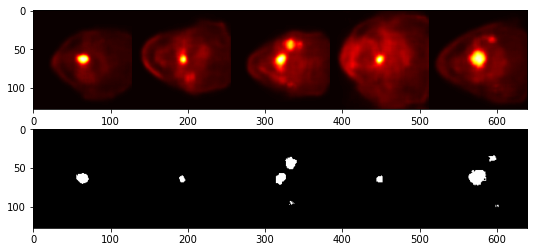

In [33]:
import matplotlib.pyplot as plt

n_sample = 5
rand_idx = np.random.randint(0, train_images.shape[0], n_sample)
print('Sample images:')
plt.figure(figsize=(20, 4))
plt.subplot(2, 1, 1)
plt.imshow(torch.hstack([img for img in train_images[rand_idx, 0]]), cmap='hot')
plt.subplot(2, 1, 2)
plt.imshow(torch.hstack([img for img in train_masks[rand_idx, 0]]), cmap='gray')
plt.show()


### Training loop and utils

In [4]:
def train_model(
        model,
        dataloader,
        n_classes = 1,
        epochs: int = 5,
        learning_rate: float = 1e-5,
        amp: bool = False,
        weight_decay: float = 1e-8,
        momentum: float = 0.999,
        gradient_clipping: float = 2.0,
        verbose = True
):

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, 1.0, 0.01, epochs)
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    criterion = nn.CrossEntropyLoss() if n_classes > 1 else nn.BCEWithLogitsLoss()
    
    train_loss = []
    for epoch in range(epochs):
        model.train()

        running_total_loss = 0.0

        progress = None
        if verbose: progress = tqdm(dataloader, position=0, leave=True)
        for i, (images, masks) in enumerate(dataloader):
            images, masks = images.to(device, dtype=torch.float32), masks.to(device, dtype=torch.long)

            with torch.autocast(device.type, enabled=amp):
                masks_pred = model(images)
                # if n_classes == 1:
                    # loss = criterion(masks_pred.squeeze(1), masks.squeeze(1).float())
                loss = dice_loss(torch.sigmoid(masks_pred.squeeze(1)).round(), masks.squeeze(1).float(), multiclass=False)
                # else:
                #     # loss = criterion(masks_pred, masks)
                #     loss = dice_loss(
                #         F.softmax(masks_pred, dim=1).float(),
                #         F.one_hot(masks, n_classes).permute(0, 3, 1, 2).float(),
                #         multiclass=True
                #     )

                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                # torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
                grad_scaler.step(optimizer)
                grad_scaler.update()
                # scheduler.step()

            running_total_loss += loss.item()

            if verbose:
                with torch.no_grad():
                    progress.update(1)
                    progress.set_description('Epoch: {:5}/{} - Actual loss: {:.4f}'.format(
                        epoch + 1, EPOCHS, running_total_loss / (i + 1)
                    ))

        train_loss.append(running_total_loss / len(dataloader))

        if verbose: progress.close()
        del progress

    import gc
    gc.collect()
    torch.cuda.empty_cache()

    return model, train_loss

def evaluate_model(model, test_loader, n_classes, device='cuda', verbose=True, **kwargs): 
    if verbose:
        print('--------------------------------------------')
        print('Test metrics (on test set)')

    model.to(device)
    model.eval()

    # criterion
    criterion = nn.CrossEntropyLoss() if n_classes > 1 else nn.BCEWithLogitsLoss()
    fn = dice_coeff if n_classes == 1 else multiclass_dice_coeff

    running_dice_score, running_ce_loss = 0.0, 0.0
    predicted_masks = []
    
    # computing predictions
    progress = None
    if verbose: progress = tqdm(test_loader, position=0, leave=True)
    for i, (images, masks) in enumerate(test_loader):
        # images, masks = images.to(device, dtype=torch.float32), masks.to(device, dtype=torch.long)
        masks_pred = model(images.to(device, dtype=torch.float32))
        masks_pred = masks_pred.detach().cpu()
        if n_classes == 1:
            running_ce_loss += criterion(masks_pred.squeeze(1), masks.squeeze(1).float())
            running_dice_score += fn(torch.sigmoid(masks_pred.squeeze(1)), masks.squeeze(1).float(), reduce_batch_first=False)
        else:
            running_ce_loss += criterion(masks_pred, masks)
            running_dice_score += fn(
                F.softmax(masks_pred, dim=1).float(),
                F.one_hot(masks, n_classes).permute(0, 3, 1, 2).float(),
                multiclass=True
            )

        if verbose: progress.update(1)

    # computing main metrics
    dice_coefficient = running_dice_score / len(test_loader)
    ce_loss = running_ce_loss / len(test_loader)

    # adding scores to the history
    stats = {}
    stats['dice_coeff'] = dice_coefficient
    stats['ce_loss'] = ce_loss
    stats['dice_loss'] = 1 - dice_coefficient

    log = """
    --------------------------------------------
    Total loss (Dice loss + CE loss): {:.3f} ↓
    Dice loss: {:.3f} ↓
    CE loss: {:.3f} ↓
    Dice coefficient: {:.3f} ↑
    --------------------------------------------
    """.format(
        1 - dice_coefficient + ce_loss, 1 - dice_coefficient, ce_loss, dice_coefficient
    )

    if verbose: print(log)

    return stats, predicted_masks


In [6]:
def assess(n_real, n_fake, n_iters, amp, epochs, factor=None, nd=3):
    # combining fake and real training data
    n_real, n_fake = n_real, n_fake
    train_images = np.concatenate((train_data[:n_real, 0], fake_data[:n_fake, 0]))
    train_masks = np.concatenate((train_data[:n_real, 1], fake_data[:n_fake, 1]))

    train_images = torch.from_numpy(train_images).type(torch.float32).unsqueeze(1)
    train_masks = torch.from_numpy(train_masks).type(torch.float32).unsqueeze(1).round()

    test_images, test_masks = test_data[:, 0], test_data[:, 1]
    test_images = torch.from_numpy(test_images).type(torch.float32).unsqueeze(1)
    test_masks = torch.from_numpy(test_masks).type(torch.float32).unsqueeze(1).round()

    if factor is not None:
        data = torch.hstack((train_images, train_masks))

        train_transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(degrees=[-90, 90]),
        ])

        data = data.repeat(factor, 1, 1, 1)
        data = torch.stack([train_transforms(data[i]) for i in range(len(data))])

        train_images = data[:, 0, None]
        train_masks = data[:, 1, None]


    # shuffling the data
    rand_idx = np.arange(train_images.__len__())
    np.random.shuffle(rand_idx)
    train_images = train_images[rand_idx]
    train_masks = train_masks[rand_idx]


    print('train_images.shape: {}'.format(train_images.shape))
    print('train_masks.shape: {}'.format(train_masks.shape))
    print('test_images.shape: {}'.format(test_images.shape))
    print('test_masks.shape: {}'.format(test_masks.shape))


    stats = []
    for _ in tqdm(range(n_iters), position=0, leave=True):
        train_loader = torch.utils.data.DataLoader(IdentityDataset(train_images, train_masks), batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
        test_loader = torch.utils.data.DataLoader(IdentityDataset(test_images, test_masks), batch_size=BATCH_SIZE, shuffle=False)

        model = UNet(n_channels=IN_CHANNELS, n_classes=1).to(device)

        model, _ = train_model(
            model, train_loader, n_classes=1, epochs=epochs, learning_rate=LEARNING_RATE, amp=amp, verbose=False
        )

        s, _ = evaluate_model(model, test_loader, n_classes=1, verbose=False)
        stats.append(s)
    
    print('mean {} - std: {}'.format(np.mean([s['dice_coeff'] for s in stats]), np.std([s['dice_coeff'] for s in stats])))
    return stats

In [ ]:
assess(n_real=-1, n_fake=0, n_iters=10, amp=True, epochs=40, factor=None)

In [38]:
assess(n_real=-1, n_fake=500, n_iters=10, amp=True, epochs=40, factor=None)

train_images.shape: torch.Size([717, 1, 128, 128])
train_masks.shape: torch.Size([717, 1, 128, 128])
test_images.shape: torch.Size([801, 1, 128, 128])
test_masks.shape: torch.Size([801, 1, 128, 128])


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [10:17<00:00, 61.77s/it]

mean 0.5960990190505981 - std: 0.040967244654893875


[{'dice_coeff': tensor(0.6319),
  'ce_loss': tensor(1.0575),
  'dice_loss': tensor(0.3681)},
 {'dice_coeff': tensor(0.5952),
  'ce_loss': tensor(0.8437),
  'dice_loss': tensor(0.4048)},
 {'dice_coeff': tensor(0.6082),
  'ce_loss': tensor(1.5596),
  'dice_loss': tensor(0.3918)},
 {'dice_coeff': tensor(0.5182),
  'ce_loss': tensor(1.6396),
  'dice_loss': tensor(0.4818)},
 {'dice_coeff': tensor(0.6407),
  'ce_loss': tensor(1.1620),
  'dice_loss': tensor(0.3593)},
 {'dice_coeff': tensor(0.6189),
  'ce_loss': tensor(0.7870),
  'dice_loss': tensor(0.3811)},
 {'dice_coeff': tensor(0.5865),
  'ce_loss': tensor(0.9686),
  'dice_loss': tensor(0.4135)},
 {'dice_coeff': tensor(0.5854),
  'ce_loss': tensor(1.7697),
  'dice_loss': tensor(0.4146)},
 {'dice_coeff': tensor(0.6448),
  'ce_loss': tensor(0.7959),
  'dice_loss': tensor(0.3552)},
 {'dice_coeff': tensor(0.5313),
  'ce_loss': tensor(1.6072),
  'dice_loss': tensor(0.4687)}]

In [39]:
assess(n_real=-1, n_fake=500, n_iters=10, amp=False, epochs=40, factor=2)

train_images.shape: torch.Size([1434, 1, 128, 128])
train_masks.shape: torch.Size([1434, 1, 128, 128])
test_images.shape: torch.Size([801, 1, 128, 128])
test_masks.shape: torch.Size([801, 1, 128, 128])


100%|██████████| 10/10 [31:27<00:00, 188.74s/it]

mean 0.6681049466133118 - std: 0.01928713545203209


[{'dice_coeff': tensor(0.6813),
  'ce_loss': tensor(10.6719),
  'dice_loss': tensor(0.3187)},
 {'dice_coeff': tensor(0.6654),
  'ce_loss': tensor(11.8987),
  'dice_loss': tensor(0.3346)},
 {'dice_coeff': tensor(0.6902),
  'ce_loss': tensor(9.4398),
  'dice_loss': tensor(0.3098)},
 {'dice_coeff': tensor(0.6633),
  'ce_loss': tensor(10.8380),
  'dice_loss': tensor(0.3367)},
 {'dice_coeff': tensor(0.6729),
  'ce_loss': tensor(11.3172),
  'dice_loss': tensor(0.3271)},
 {'dice_coeff': tensor(0.6657),
  'ce_loss': tensor(13.2769),
  'dice_loss': tensor(0.3343)},
 {'dice_coeff': tensor(0.6650),
  'ce_loss': tensor(13.5668),
  'dice_loss': tensor(0.3350)},
 {'dice_coeff': tensor(0.6167),
  'ce_loss': tensor(16.5277),
  'dice_loss': tensor(0.3833)},
 {'dice_coeff': tensor(0.6756),
  'ce_loss': tensor(15.7124),
  'dice_loss': tensor(0.3244)},
 {'dice_coeff': tensor(0.6849),
  'ce_loss': tensor(7.5709),
  'dice_loss': tensor(0.3151)}]

## 3D UNet

In [ ]:
import torch
from modules.unet import UNet
from tqdm import tqdm
import numpy as np
from modules.unet import dice_loss, dice_coeff, multiclass_dice_coeff

EPOCHS = 100

class IdentityDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.x)

real_data = np.load('data/second_stage_dataset_192x192_200.npy')
real_data[:, 1] = np.where(real_data[:, 1] > 0, 1, 0)


train_data, test_data = real_data[0:100], real_data[100:]  # 30 samples for training, 30 for testing

train_images = torch.from_numpy(train_data[:, 0, None]).type(torch.float32)
train_masks = torch.from_numpy(train_data[:, 1, None]).type(torch.float32).round()

test_images, test_masks = test_data[:, 0, None], test_data[:, 1, None]
test_images = torch.from_numpy(test_images).type(torch.float32)
test_masks = torch.from_numpy(test_masks).type(torch.float32).round()

# shuffling the data
rand_idx = np.arange(train_images.__len__())
np.random.shuffle(rand_idx)
train_images = train_images[rand_idx]
train_masks = train_masks[rand_idx]

print('train_images.shape: {}'.format(train_images.shape))
print('train_masks.shape: {}'.format(train_masks.shape))
print('test_images.shape: {}'.format(test_images.shape))
print('test_masks.shape: {}'.format(test_masks.shape))
print('max : {}'.format(train_images.max()))
print('min : {}'.format(train_images.min()))

train_loader = torch.utils.data.DataLoader(IdentityDataset(train_images, train_masks), batch_size=2, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(IdentityDataset(test_images, test_masks), batch_size=1, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Training

amp = False
model = UNet(n_channels=1, n_classes=1, nd=3).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
# criterion = nn.BCEWithLogitsLoss()

train_loss = []
for epoch in range(EPOCHS):
    model.train()

    running_total_loss = 0.0

    progress = tqdm(train_loader, position=0, leave=True)
    for i, (images, masks) in enumerate(train_loader):
        images, masks = images.to(device, dtype=torch.float32), masks.to(device, dtype=torch.long)

        with torch.autocast(device.type, enabled=amp):
            masks_pred = model(images)
            loss = dice_loss(torch.sigmoid(masks_pred.squeeze(1)), masks.squeeze(1).float())

            optimizer.zero_grad(set_to_none=True)
            grad_scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
            grad_scaler.step(optimizer)
            grad_scaler.update()

        running_total_loss += loss.item()

        with torch.no_grad():
            progress.update(1)
            progress.set_description('Epoch: {:5}/{} - Actual loss: {:.4f}'.format(
                epoch + 1, EPOCHS, running_total_loss / (i + 1)
            ))

    train_loss.append(running_total_loss / len(train_loader))

    progress.close()
    del progress

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(n_channels=1, n_classes=1, nd=3).to(device)

model

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Sequential(
        (0): Conv3d(1, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): ReLU(inplace=True)
      (2): Sequential(
        (0): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (3): ReLU(inplace=True)
    )
  )
  (down2): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Sequential(
        (0): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1))
        (1): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (down3): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool3d(kernel_si

In [11]:
evaluate_model(model, test_loader, n_classes=1, verbose=True)

--------------------------------------------
Test metrics (on test set)


100%|██████████| 30/30 [00:04<00:00,  6.25it/s]


    --------------------------------------------
    Total loss (Dice loss + CE loss): 1.769 ↓
    Dice loss: 0.894 ↓
    CE loss: 0.875 ↓
    Dice coefficient: 0.106 ↑
    --------------------------------------------
    


({'dice_coeff': tensor(0.1058),
  'ce_loss': tensor(0.8751),
  'dice_loss': tensor(0.8942)},
 [])

## Qualitative evaluations

In [10]:
def evaluate_samples(real, fake, verbose=True, device='cuda', **kwargs): 
    if verbose:
        print('--------------------------------------------')
        print('Test metrics (on test set)')

    # recon = []
    # # computing predictions
    # for i, x in enumerate(tqdm(test_loader, position=0, leave=True)):
    #     x = x.to(device, dtype=torch.float32)
    #     output = model(x)
    #     stats = model.loss_function(output['x'], x, output['mu'], output['logvar'])
    #     recon.append(output['x'])
    stats = dict()

    # # computing main metrics
    # elbo = stats['loss'].item()
    # recon_loss = stats['recon_loss'].item()
    # kld_loss = stats['kld_loss'].item()

    # real = torch.vstack([img for img in test_loader]).to(device, dtype=torch.float32)
    # recon = torch.vstack([img for img in recon]).to(device, dtype=torch.float32)
    # fake = model.sample(n_samples=len(test_loader))

    print('Evaluation on {} real/fake/recon images'.format(len(real)))

    # computing ssim and psnr from outputs
    psnr = PeakSignalNoiseRatio().to(device)
    psnr_score = psnr(fake, real)
    ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
    ssim_score = ssim(fake, real)
    
    if real.shape[1] == 1:
        real = real.repeat(1, 3, 1, 1)
        fake = fake.repeat(1, 3, 1, 1)
        # recon = recon.repeat(1, 3, 1, 1)

    fid = FrechetInceptionDistance(normalize=True).to(device)
    fid.update(real, real=True)
    fid.update(fake, real=False)
    fid_score = fid.compute()
    incep = InceptionScore(normalize=True).to(device)
    incep.update(fake)
    mean_is_score, std_is_score = incep.compute()
    is_score = torch.exp(mean_is_score) / torch.sqrt(std_is_score)
    lpips = LearnedPerceptualImagePatchSimilarity(net_type='vgg', normalize=True).to(device)
    lpips_score = lpips(real, fake)

    # adding scores to the history
    stats['psnr'] = psnr_score
    stats['ssim'] = ssim_score
    stats['fid'] = fid_score
    stats['is'] = (mean_is_score, std_is_score, is_score)
    stats['lpips'] = lpips_score

    log = """
    --------------------------------------------
    Total loss (ELBO): {:.3f} ↓
    Mean squared error: {:.3f} ↓
    Kullback-Leibler divergence: {:.3f} ↓
    PSNR: {:.3f} ↑
    SSIM: {:.3f} ↑
    FID: {:.3f} ↓
    IS: (mean) {:.3f} (std) {:.3f} : {:.3f} ↑
    LPIPS: {:.3f} ↓
    kwargs: {}
    --------------------------------------------
    """.format(
        0, 0, 0, psnr_score, ssim_score, fid_score, mean_is_score, 
        std_is_score, is_score, lpips_score, kwargs
    )

    if verbose: print(log)

    return stats


### HECKTOR dHVAE-HECKTOR (original)

In [115]:
fake_data = np.load('data/dHVAE-HECKTOR (original).npy')
fake_images = fake_data[:test_images.shape[0], 0, None]
# min max norm to 0-1
for idx in range(len(fake_images)):
    fake_images[idx] = (fake_images[idx] - fake_images[idx].min()) / (fake_images[idx].max() - fake_images[idx].min())

fake_images = torch.from_numpy(fake_images).type(torch.float32).to(device)
test_images = test_images.to(device)

stats = evaluate_samples(test_images, fake_images, verbose=True, device=device)

--------------------------------------------
Test metrics (on test set)
Evaluation on 609 real/fake/recon images


/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



    --------------------------------------------
    Total loss (ELBO): 0.000 ↓
    Mean squared error: 0.000 ↓
    Kullback-Leibler divergence: 0.000 ↓
    PSNR: 19.115 ↑
    SSIM: 0.600 ↑
    FID: 74.428 ↓
    IS: (mean) 1.027 (std) 0.020 : 19.854 ↑
    LPIPS: 0.310 ↓
    kwargs: {}
    --------------------------------------------
    


### AHVAE - HECKTOR

In [11]:
fake_data = np.load('data/generated_AHVAE_128_128_ds - hecktor_mask - True.npy')
fake_images = fake_data[:test_images.shape[0], 0, None]
# min max norm to 0-1
for idx in range(len(fake_images)):
    fake_images[idx] = (fake_images[idx] - fake_images[idx].min()) / (fake_images[idx].max() - fake_images[idx].min())

fake_images = torch.from_numpy(fake_images).type(torch.float32).to(device)
test_images = test_images.to(device)

stats = evaluate_samples(test_images, fake_images, verbose=True, device=device)


--------------------------------------------
Test metrics (on test set)
Evaluation on 609 real/fake/recon images


/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



    --------------------------------------------
    Total loss (ELBO): 0.000 ↓
    Mean squared error: 0.000 ↓
    Kullback-Leibler divergence: 0.000 ↓
    PSNR: 19.570 ↑
    SSIM: 0.580 ↑
    FID: 54.008 ↓
    IS: (mean) 1.063 (std) 0.023 : 19.259 ↑
    LPIPS: 0.309 ↓
    kwargs: {}
    --------------------------------------------
    


### VAE (HECKTOR)

In [12]:
fake_data = np.load('data/generated_VAE_128_128_ds=hecktor, mask=True.npy')
fake_images = fake_data[:test_images.shape[0], 0, None]
# min max norm to 0-1
for idx in range(len(fake_images)):
    fake_images[idx] = (fake_images[idx] - fake_images[idx].min()) / (fake_images[idx].max() - fake_images[idx].min())

fake_images = torch.from_numpy(fake_images).type(torch.float32).to(device)
test_images = test_images.to(device)

stats = evaluate_samples(test_images, fake_images, verbose=True, device=device)


--------------------------------------------
Test metrics (on test set)
Evaluation on 609 real/fake/recon images


/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



    --------------------------------------------
    Total loss (ELBO): 0.000 ↓
    Mean squared error: 0.000 ↓
    Kullback-Leibler divergence: 0.000 ↓
    PSNR: 19.038 ↑
    SSIM: 0.567 ↑
    FID: 90.208 ↓
    IS: (mean) 1.037 (std) 0.024 : 18.132 ↑
    LPIPS: 0.338 ↓
    kwargs: {}
    --------------------------------------------
    


### LSGAN (HECKTOR)

In [8]:
fake_data = np.load('data/generated_LSGAN_128_128_ds - hecktor_mask - True.npy')
fake_images = fake_data[:test_images.shape[0], 0, None]
# min max norm to 0-1
for idx in range(len(fake_images)):
    fake_images[idx] = (fake_images[idx] - fake_images[idx].min()) / (fake_images[idx].max() - fake_images[idx].min())

fake_images = torch.from_numpy(fake_images).type(torch.float32).to(device)
test_images = test_images.to(device)

stats = evaluate_samples(test_images, fake_images, verbose=True, device=device)


--------------------------------------------
Test metrics (on test set)
Evaluation on 609 real/fake/recon images


/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



    --------------------------------------------
    Total loss (ELBO): 0.000 ↓
    Mean squared error: 0.000 ↓
    Kullback-Leibler divergence: 0.000 ↓
    PSNR: 18.440 ↑
    SSIM: 0.488 ↑
    FID: 189.753 ↓
    IS: (mean) 1.773 (std) 0.126 : 16.555 ↑
    LPIPS: 0.459 ↓
    kwargs: {}
    --------------------------------------------
    


### BRATS - AHVAE

In [36]:
fake_data = np.load('data/generated_AHVAE_128_128_ds - brats_mask - True.npy')
fake_data = transforms.RandomHorizontalFlip(p=1.0)(torch.from_numpy(fake_data)).numpy()
fake_images = fake_data[:test_images.shape[0], 0, None]
# min max norm to 0-1
for idx in range(len(fake_images)):
    fake_images[idx] = (fake_images[idx] - fake_images[idx].min()) / (fake_images[idx].max() - fake_images[idx].min())

fake_images = torch.from_numpy(fake_images).type(torch.float32).to(device)
test_images = test_images.to(device)

stats = evaluate_samples(test_images, fake_images, verbose=True, device=device)


--------------------------------------------
Test metrics (on test set)
Evaluation on 838 real/fake/recon images


/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



    --------------------------------------------
    Total loss (ELBO): 0.000 ↓
    Mean squared error: 0.000 ↓
    Kullback-Leibler divergence: 0.000 ↓
    PSNR: 15.582 ↑
    SSIM: 0.647 ↑
    FID: 94.679 ↓
    IS: (mean) 1.569 (std) 0.054 : 20.587 ↑
    LPIPS: 0.227 ↓
    kwargs: {}
    --------------------------------------------
    


### Brats - VAE

In [40]:
fake_data = np.load('data/generated_VAE_128_128_ds=brats, mask=True.npy')
fake_data = transforms.RandomHorizontalFlip(p=1.0)(torch.from_numpy(fake_data)).numpy()
fake_images = fake_data[:test_images.shape[0], 0, None]
# min max norm to 0-1
for idx in range(len(fake_images)):
    fake_images[idx] = (fake_images[idx] - fake_images[idx].min()) / (fake_images[idx].max() - fake_images[idx].min())

fake_images = torch.from_numpy(fake_images).type(torch.float32).to(device)
test_images = test_images.to(device)

stats = evaluate_samples(test_images, fake_images, verbose=True, device=device)


--------------------------------------------
Test metrics (on test set)
Evaluation on 838 real/fake/recon images


/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



    --------------------------------------------
    Total loss (ELBO): 0.000 ↓
    Mean squared error: 0.000 ↓
    Kullback-Leibler divergence: 0.000 ↓
    PSNR: 15.181 ↑
    SSIM: 0.644 ↑
    FID: 106.276 ↓
    IS: (mean) 1.730 (std) 0.144 : 14.853 ↑
    LPIPS: 0.273 ↓
    kwargs: {}
    --------------------------------------------
    


### HVAE BRATS

In [41]:
fake_data = np.load('data/generated_HVAE_128_128_ds - brats, mask - True, dt - 0.1.npy')
fake_data = transforms.RandomHorizontalFlip(p=1.0)(torch.from_numpy(fake_data)).numpy()
fake_images = fake_data[:test_images.shape[0], 0, None]
# min max norm to 0-1
for idx in range(len(fake_images)):
    fake_images[idx] = (fake_images[idx] - fake_images[idx].min()) / (fake_images[idx].max() - fake_images[idx].min())

fake_images = torch.from_numpy(fake_images).type(torch.float32).to(device)
test_images = test_images.to(device)

stats = evaluate_samples(test_images, fake_images, verbose=True, device=device)


--------------------------------------------
Test metrics (on test set)
Evaluation on 838 real/fake/recon images


/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



    --------------------------------------------
    Total loss (ELBO): 0.000 ↓
    Mean squared error: 0.000 ↓
    Kullback-Leibler divergence: 0.000 ↓
    PSNR: 15.336 ↑
    SSIM: 0.655 ↑
    FID: 124.750 ↓
    IS: (mean) 1.312 (std) 0.057 : 15.542 ↑
    LPIPS: 0.248 ↓
    kwargs: {}
    --------------------------------------------
    


## LSGAN BRATS

In [47]:
fake_images = np.load('data/generated_LSGAN_128_128_ds - brats_mask - True.npy')
fake_images = transforms.RandomHorizontalFlip(p=1.0)(torch.from_numpy(fake_data)).numpy()
# min max norm to 0-1
for idx in range(len(fake_images)):
    fake_images[idx] = (fake_images[idx] - fake_images[idx].min()) / (fake_images[idx].max() - fake_images[idx].min())

fake_images = torch.from_numpy(fake_images).type(torch.float32).to(device)
test_images = test_images[:500].to(device)

stats = evaluate_samples(test_images, fake_images, verbose=True, device=device)


--------------------------------------------
Test metrics (on test set)
Evaluation on 500 real/fake/recon images


/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



    --------------------------------------------
    Total loss (ELBO): 0.000 ↓
    Mean squared error: 0.000 ↓
    Kullback-Leibler divergence: 0.000 ↓
    PSNR: 14.579 ↑
    SSIM: 0.442 ↑
    FID: 158.289 ↓
    IS: (mean) 1.856 (std) 0.066 : 24.832 ↑
    LPIPS: 0.473 ↓
    kwargs: {}
    --------------------------------------------
    


## BRATS - dHVAE old training with new data

In [53]:
fake_data = np.load('data/dHVAE-BRATS (original).npy')
fake_data = transforms.RandomHorizontalFlip(p=1.0)(torch.from_numpy(fake_data)).numpy()
fake_images = fake_data[:test_images.shape[0], 0, None]
# min max norm to 0-1
for idx in range(len(fake_images)):
    fake_images[idx] = (fake_images[idx] - fake_images[idx].min()) / (fake_images[idx].max() - fake_images[idx].min())

fake_images = torch.from_numpy(fake_images).type(torch.float32).to(device)
test_images = test_images.to(device)

stats = evaluate_samples(test_images, fake_images, verbose=True, device=device)


--------------------------------------------
Test metrics (on test set)
Evaluation on 838 real/fake/recon images


/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



    --------------------------------------------
    Total loss (ELBO): 0.000 ↓
    Mean squared error: 0.000 ↓
    Kullback-Leibler divergence: 0.000 ↓
    PSNR: 15.614 ↑
    SSIM: 0.647 ↑
    FID: 92.488 ↓
    IS: (mean) 1.582 (std) 0.052 : 21.427 ↑
    LPIPS: 0.227 ↓
    kwargs: {}
    --------------------------------------------
    


### dHVAE - BRATS (0.01) = 0.05

In [8]:
fake_data = np.load('data/dHVAE-BRATS (0.05).npy')
fake_data = transforms.RandomHorizontalFlip(p=1.0)(torch.from_numpy(fake_data)).numpy()
fake_images = fake_data[:test_images.shape[0], 0, None]
# min max norm to 0-1
for idx in range(len(fake_images)):
    fake_images[idx] = (fake_images[idx] - fake_images[idx].min()) / (fake_images[idx].max() - fake_images[idx].min())

fake_images = torch.from_numpy(fake_images).type(torch.float32).to(device)
test_images = test_images.to(device)

stats = evaluate_samples(test_images, fake_images, verbose=True, device=device)


--------------------------------------------
Test metrics (on test set)
Evaluation on 838 real/fake/recon images


/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



    --------------------------------------------
    Total loss (ELBO): 0.000 ↓
    Mean squared error: 0.000 ↓
    Kullback-Leibler divergence: 0.000 ↓
    PSNR: 13.795 ↑
    SSIM: 0.578 ↑
    FID: 123.964 ↓
    IS: (mean) 1.719 (std) 0.086 : 19.076 ↑
    LPIPS: 0.283 ↓
    kwargs: {}
    --------------------------------------------
    


## BRATS - dHVAE (0.001) = 0.0005

In [7]:
fake_data = np.load('data/dHVAE-BRATS (0.05).npy')
# fake_data = transforms.RandomHorizontalFlip(p=1.0)(torch.from_numpy(fake_data)).numpy()
fake_images = fake_data[:test_images.shape[0], 0, None]
# min max norm to 0-1
for idx in range(len(fake_images)):
    fake_images[idx] = (fake_images[idx] - fake_images[idx].min()) / (fake_images[idx].max() - fake_images[idx].min())

fake_images = torch.from_numpy(fake_images).type(torch.float32).to(device)
test_images = test_images.to(device)

stats = evaluate_samples(test_images, fake_images, verbose=True, device=device)


--------------------------------------------
Test metrics (on test set)
Evaluation on 838 real/fake/recon images


/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



    --------------------------------------------
    Total loss (ELBO): 0.000 ↓
    Mean squared error: 0.000 ↓
    Kullback-Leibler divergence: 0.000 ↓
    PSNR: 15.409 ↑
    SSIM: 0.632 ↑
    FID: 126.503 ↓
    IS: (mean) 1.707 (std) 0.055 : 23.470 ↑
    LPIPS: 0.233 ↓
    kwargs: {}
    --------------------------------------------
    


## dHVAE - BRATS (0.1) = 0.5

In [7]:
fake_data = np.load('data/dHVAE-BRATS (0.1).npy')
# fake_data = transforms.RandomHorizontalFlip(p=1.0)(torch.from_numpy(fake_data)).numpy()
fake_images = fake_data[:test_images.shape[0], 0, None]
# min max norm to 0-1
for idx in range(len(fake_images)):
    fake_images[idx] = (fake_images[idx] - fake_images[idx].min()) / (fake_images[idx].max() - fake_images[idx].min())

fake_images = torch.from_numpy(fake_images).type(torch.float32).to(device)
test_images = test_images.to(device)

stats = evaluate_samples(test_images, fake_images, verbose=True, device=device)


--------------------------------------------
Test metrics (on test set)
Evaluation on 838 real/fake/recon images


/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



    --------------------------------------------
    Total loss (ELBO): 0.000 ↓
    Mean squared error: 0.000 ↓
    Kullback-Leibler divergence: 0.000 ↓
    PSNR: 15.208 ↑
    SSIM: 0.633 ↑
    FID: 147.453 ↓
    IS: (mean) 1.671 (std) 0.049 : 24.154 ↑
    LPIPS: 0.235 ↓
    kwargs: {}
    --------------------------------------------
    


## dHVAE - BRATS (0.01) Fethi

In [8]:
fake_data = np.load('data/dHVAE-BRATS (0.01) Fethi.npy')
# fake_data = transforms.RandomHorizontalFlip(p=1.0)(torch.from_numpy(fake_data)).numpy()
fake_images = fake_data[:test_images.shape[0], 0, None]
# min max norm to 0-1
for idx in range(len(fake_images)):
    fake_images[idx] = (fake_images[idx] - fake_images[idx].min()) / (fake_images[idx].max() - fake_images[idx].min())

fake_images = torch.from_numpy(fake_images).type(torch.float32).to(device)
test_images = test_images.to(device)

stats = evaluate_samples(test_images, fake_images, verbose=True, device=device)


--------------------------------------------
Test metrics (on test set)
Evaluation on 838 real/fake/recon images


/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



    --------------------------------------------
    Total loss (ELBO): 0.000 ↓
    Mean squared error: 0.000 ↓
    Kullback-Leibler divergence: 0.000 ↓
    PSNR: 15.622 ↑
    SSIM: 0.627 ↑
    FID: 88.299 ↓
    IS: (mean) 1.817 (std) 0.075 : 22.525 ↑
    LPIPS: 0.229 ↓
    kwargs: {}
    --------------------------------------------
    


# HVAE + Percep

In [8]:
fake_data = np.load('data/HVAE-Percep-BRATS.npy')
# fake_data = transforms.RandomHorizontalFlip(p=1.0)(torch.from_numpy(fake_data)).numpy()
fake_images = fake_data[:test_images.shape[0], 0, None]
# min max norm to 0-1
for idx in range(len(fake_images)):
    fake_images[idx] = (fake_images[idx] - fake_images[idx].min()) / (fake_images[idx].max() - fake_images[idx].min())

fake_images = torch.from_numpy(fake_images).type(torch.float32).to(device)
test_images = test_images.to(device)

stats = evaluate_samples(test_images, fake_images, verbose=True, device=device)


--------------------------------------------
Test metrics (on test set)
Evaluation on 838 real/fake/recon images

    --------------------------------------------
    Total loss (ELBO): 0.000 ↓
    Mean squared error: 0.000 ↓
    Kullback-Leibler divergence: 0.000 ↓
    PSNR: 14.923 ↑
    SSIM: 0.637 ↑
    FID: 104.767 ↓
    IS: (mean) 1.600 (std) 0.052 : 21.715 ↑
    LPIPS: 0.225 ↓
    kwargs: {}
    --------------------------------------------
    


## HVAE + Disc

In [7]:
fake_data = np.load('data/HVAE-Disc-Brats.npy')
# fake_data = transforms.RandomHorizontalFlip(p=1.0)(torch.from_numpy(fake_data)).numpy()
fake_images = fake_data[:test_images.shape[0], 0, None]
# min max norm to 0-1
for idx in range(len(fake_images)):
    fake_images[idx] = (fake_images[idx] - fake_images[idx].min()) / (fake_images[idx].max() - fake_images[idx].min())

fake_images = torch.from_numpy(fake_images).type(torch.float32).to(device)
test_images = test_images.to(device)

stats = evaluate_samples(test_images, fake_images, verbose=True, device=device)


--------------------------------------------
Test metrics (on test set)
Evaluation on 838 real/fake/recon images


/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



    --------------------------------------------
    Total loss (ELBO): 0.000 ↓
    Mean squared error: 0.000 ↓
    Kullback-Leibler divergence: 0.000 ↓
    PSNR: 15.102 ↑
    SSIM: 0.633 ↑
    FID: 147.954 ↓
    IS: (mean) 1.681 (std) 0.085 : 18.456 ↑
    LPIPS: 0.237 ↓
    kwargs: {}
    --------------------------------------------
    


---------------------------------------------------------------------------